In [1]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, GaussianNB # 导入不同类型的朴素贝叶斯分类器
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # 导入文本特征提取工具：词频和TF-IDF向量化器
from sklearn import preprocessing, tree, ensemble, svm, metrics, calibration  # 导入预处理、决策树、集成方法、支持向量机、评价指标等模块
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import auc, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import text
from matplotlib import pyplot as plt
from itertools import combinations
from wordcloud import WordCloud # 导入生成词云的工具
from collections import Counter
from textblob import TextBlob # 导入文本情感分析工具
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import math


In [2]:
train_df = pd.read_csv("train.csv",sep="\t")
test_df = pd.read_csv("test.csv",sep="\t",index_col=False)
train_df.describe()

,reviewerID,asin,overall,votes_up,votes_all,label
count,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000
mean,33359.761865,19973.170866,3.535178,12.387594,18.475850,0.226196
std,30016.804127,14104.410152,1.529742,45.130499,50.149683,0.418371
min,50.000000,0.000000,1.000000,0.000000,5.000000,0.000000
25%,9235.000000,8218.000000,2.000000,4.000000,6.000000,0.000000
50%,22589.000000,17635.000000,4.000000,6.000000,10.000000,0.000000
75%,53170.000000,30875.000000,5.000000,11.000000,18.000000,0.000000
max,123767.000000,50051.000000,5.000000,6084.000000,6510.000000,1.000000


In [3]:
test_df.describe()

,Id,reviewerID,asin,reviewText,overall
count,22418,22417,22417,22417,22417
unique,11210,4585,6492,11209,6
top,0,1053,1907,I REALLY wanted this series but I am in SHOCK ...,5
freq,2,28,56,2,9204


In [4]:
print(train_df.shape)

(57039, 7)


In [5]:
print(test_df.shape)

(22418, 5)


In [6]:
labels=pd.read_csv("pre_l.csv")
labels._append(labels)

,label
0,0
1,0
2,0
3,0
4,0
...,...
11203,0
11204,0
11205,0
11206,0


In [7]:
test_df["label"] = labels
test_df.head()

,Id,reviewerID,asin,reviewText,overall,label
0,0,82947,37386,I REALLY wanted this series but I am in SHOCK ...,1,0.0
1,1,10154,23543,I have to say that this is a work of art for m...,4,0.0
2,2,5789,5724,Alien 3 is certainly the most controversal fil...,3,0.0
3,3,9198,5909,"I love this film...preachy? Well, of course i...",5,0.0
4,4,33252,21214,Even though I previously bought the Gamera Dou...,5,0.0


In [8]:
test_df.drop("Id",axis=1,inplace=True)

In [9]:
train_df["length"] = train_df["reviewText"].map(lambda x: len(x.split(" ")))
# 使用了TextBlob库中的sentiment方法，该方法返回一个元组，第一个元素是极性值，第二个元素是主观性值
train_df["polarity"] = train_df["reviewText"].map(lambda x : TextBlob(str(x)).sentiment[0])

test_df["length"] = test_df["reviewText"].map(lambda x: len(str(x).split(" ")))
# 使用了TextBlob库中的sentiment方法，该方法返回一个元组，第一个元素是极性值，第二个元素是主观性值
test_df["polarity"] = test_df["reviewText"].map(lambda x : TextBlob(str(x)).sentiment[0])

In [10]:
test_df.describe()

,label,length,polarity
count,11208.000000,22418.000000,22418.000000
mean,0.191827,256.192256,0.138560
std,0.393756,241.774872,0.171641
min,0.000000,1.000000,-1.000000
25%,0.000000,101.000000,0.050509
50%,0.000000,188.000000,0.140980
75%,0.000000,328.000000,0.231422
max,1.000000,5320.000000,1.000000


In [11]:
print("训练集和测试集的比例为：",test_df.shape[0]/train_df.shape[0])    

训练集和测试集的比例为： 0.3930293308087449


In [12]:
# 将文本数据向量化
def get_vectorizer(method,min_df,max_df,max_features,stop_words):
    if method=="count":
        return CountVectorizer(min_df=min_df,max_df=max_df,max_features=max_features,stop_words=stop_words)
    if method =="tfidf":
        return TfidfVectorizer(min_df=min_df,max_df=max_df,max_features=max_features,stop_words=stop_words,ngram_range=(1,1))

def tranfrom_data(vectorizer,data):
    return vectorizer.transform(data).toarray()

def vectorize(train_data,test_data=None,min_df = 0.019,max_df = 1.0,max_features=1000,stop_words="english",method="tfidf"):
    vectorizer = get_vectorizer(method,min_df,max_df,max_features,stop_words)
    vectorizer_model = vectorizer.fit(train_data)
    features = tranfrom_data(vectorizer,train_data)
    if not test_data.empty:
        test_features = tranfrom_data(vectorizer, test_data)
    else:
        test_features = None
    return features, test_features

In [13]:
features, test_features = vectorize(train_df['reviewText'], test_df['reviewText'].apply(lambda x: np.str_(x)))
print('features.shape:')
print(features.shape, test_features.shape if test_features is not None else None)



features.shape:
(57039, 870) (22418, 870)


In [14]:
test_df.fillna(0.0,inplace=True)
test_df.head()

,reviewerID,asin,reviewText,overall,label,length,polarity
0,82947,37386,I REALLY wanted this series but I am in SHOCK ...,1,0.0,39,0.200000
1,10154,23543,I have to say that this is a work of art for m...,4,0.0,169,0.296491
2,5789,5724,Alien 3 is certainly the most controversal fil...,3,0.0,365,0.016857
3,9198,5909,"I love this film...preachy? Well, of course i...",5,0.0,71,0.333766
4,33252,21214,Even though I previously bought the Gamera Dou...,5,0.0,78,0.246667


In [15]:
test_df[test_df['overall']=='overall']

,reviewerID,asin,reviewText,overall,label,length,polarity
11209,reviewerID,asin,reviewText,overall,0.0,1,0.0


In [16]:
test_df['overall'].iloc[11209]=0.0

C:\Users\Guoxn\AppData\Local\Temp\ipykernel_32192\410914053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['overall'].iloc[11209]=0.0


In [17]:
X_train = np.concatenate(
    [features, train_df[['overall', 'length', 'polarity']]], axis=1)
X_train = preprocessing.MinMaxScaler().fit_transform(X_train)

X_test = np.concatenate(
    [test_features, test_df[['overall', 'length', 'polarity']]], axis=1)
X_test = preprocessing.MinMaxScaler().fit_transform(X_test)


In [18]:
X_train.shape

(57039, 873)

In [111]:
from sklearn import calibration, svm, tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def get_classifiers():
    # 返回一个字典，包含了不同分类器的名称和对应的分类器对象
    return {
        'LinearSVM': calibration.CalibratedClassifierCV(svm.LinearSVC(loss='squared_hinge', dual=False)),
        'DecisionTree': tree.DecisionTreeClassifier(criterion='gini', max_depth=5, splitter='random'),
        'MultBayes': MultinomialNB(alpha=1, fit_prior=True, class_prior=[0.8, 0.2]),
        'Knn': KNeighborsClassifier(n_neighbors=3)
    }

def train_and_evaluate(clf, X_train, y_train):
    # 训练分类器并计算准确率
    clf.fit(X_train[:10000], y_train[:10000])
    predictions = clf.predict(X_train)
    accuracy = accuracy_score(predictions, y_train)
    return accuracy

# 获取不同分类器的名称和对应的分类器对象
classifiers = get_classifiers()

# 对每个分类器进行训练和评估
for classifier_name, classifier in classifiers.items():
    accuracy = train_and_evaluate(classifier, X_train, train_df['label'])
    print(f"Accuracy of {classifier_name}: {accuracy}")


Accuracy of LinearSVM: 0.7878644436262908
Accuracy of DecisionTree: 0.7753817563421519
Accuracy of MultBayes: 0.7810971440593278
Accuracy of Knn: 0.7782920457932292


In [112]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def averange(results):
    return np.average(results,axis=1)

# 定义函数weight_average，计算加权结果的平均值
def weight_average(results, weights):
    return np.dot(results, weights) / np.sum(weights)

# 定义函数vote，计算标签的平均值
def vote(labels):
    return np.average(labels, axis=1)

# 定义函数weight_vote，计算加权标签的平均值
def weight_vote(labels, weights):
    return np.dot(labels, weights) / np.sum(weights)

def plot_results(y,pres,methods,cls_name):
    fig = plt.figure(figsize=(10,10))
    for idx,method in enumerate(methods):
        pre = pres[idx]
        fpr,tpr,thresholds = metrics.roc_curve(y,pre,pos_label=1)
        plt.subplot(2, 2, idx+1)
        plt.plot(fpr, tpr, lw=2)
        auc = metrics.auc(fpr, tpr)

        pre[pre>=0.5],pre[pre<0.5] = 1,0
        acc = accuracy_score(pre,y)
        plt.title('Method: %s    Auc: %.2f    Acc: %.2f' % (method, auc, acc))
    plt.suptitle('Classifier: '+str(cls_name))

def weight(results,labels,weights,y,cls_name):
    results,labels,weights = np.array(results).T,np.array(labels).T, np.array(weights)
    methods = ['average', 'weight-average', 'vote', 'weight-vote']
    pres = [averange(results), weight_average(results, weights), vote(labels), weight_vote(labels, weights)]
    plot_results(y,pres,methods,cls_name)

In [113]:
import numpy as np
import random
import math
from sklearn.metrics import accuracy_score

import random

def draw_samples(datas,sample_size,feature_size):
    sample_indices = random.sample(range(datas[0].shape[0]),sample_size)
    feature_indices = random.sample(range(datas[0].shape[1]),feature_size)
    return sample_indices,feature_indices

def fit_and_predict(clf,datas,sample_indecs,feature_indices):
    
    clf.fit(datas[0][sample_indecs][:,feature_indices],datas[1][sample_indecs])
    predictions = np.array([p[1] for p in clf.predict_proba(datas[2][:,feature_indices])])
    return predictions

def create_labels(predictions,threshold):
    labels = predictions.copy()
    labels[labels>threshold],labels[labels<threshold] = 1,0
    return labels


In [114]:
import numpy as np
# 确定阈值的范围
# 获取标签列并计算 0 的个数
labels1 = train_df['label']
zeros_count1 = np.count_nonzero(labels1 == 0)

# 计算占比
total_samples1 = len(labels1)
zeros_ratio1 = zeros_count1 / total_samples1


labels2 = test_df['label']
zeros_count2 = np.count_nonzero(labels2 == 0)

# 计算占比
total_samples2 = len(labels2)
zeros_ratio2 = zeros_count2 / total_samples2
print("训练集")
print("0 的个数：", zeros_count1)
print("0 的占比：", zeros_ratio1)
print("测试集")
print("0 的个数：", zeros_count2)
print("0 的占比：", zeros_ratio2)
# 77 - 90 都可以

训练集
0 的个数： 44137
0 的占比： 0.7738038885674714
测试集
0 的个数： 20268
0 的占比： 0.9040949237220091


In [115]:
def bagging(base_estimators,datas,n_estimators=10,max_samples = 0.1,max_features = 0.5):
    assert(n_estimators>0 and max_samples>0 and max_features>0)
    result,labels,weights = [],[],[]
    sample_size,feature_size = int(max_samples*datas[0].shape[0]),int(max_features*datas[0].shape[1])
    for clf in base_estimators:
        for _ in range(n_estimators):
            sample_indices,feature_indices = draw_samples(datas,sample_size,feature_size)

            predictions = fit_and_predict(clf,datas,sample_indices,feature_indices)
            result.append(predictions)
            # 取阈值为0.85，在0.77-0.90之间 没问题
            labels.append(create_labels(predictions,np.sort(predictions)[int(0.85*len(predictions))]))
            labels[-1] = labels[-1].astype(int)
            weights.append([accuracy_score(labels[-1],(datas[3]))])
    
    return result,labels,weights

            

In [121]:
def adaboost(base_estimator,datas,n_estimators=30,learning_rate=1.0,max_samples=0.05,max_features=1.0):
    assert (n_estimators > 0 and max_samples > 0 and max_features > 0)
    results,labels,weights = [],[],[]
    sample_size,feature_size = int(max_samples*datas[0].shape[0]),int(max_features*datas[0].shape[1])
    clf = base_estimator
    sample_weigths = np.array([1/datas[0].shape[0] for _ in range(datas[0].shape[0])])

    for _ in range(n_estimators):
        sample_indices,feature_indices = draw_samples(datas,sample_size,feature_size)
        
        predictions = fit_and_predict(clf,datas,sample_indices,feature_indices)
        # 计算错误分类的情况，并为其调整权重参数
        # 异或操作
        misclassified = np.array(clf.predict(datas[0][sample_indices,:][:,feature_indices])) ^ datas[1][sample_indices]
        error = np.sum(sample_weigths[sample_indices][misclassified==1])
        if error > 0.5:
            print('ERROR more than half.')
            break
        sample_weigths[sample_indices][misclassified==1] *= learning_rate*error/(1-error)
        
        sample_weigths /= np.sum(sample_weigths)
        results.append(predictions)
        labels.append(create_labels(predictions, np.sort(predictions)[int(0.8 * len(predictions))]))
        weights.append(1/2 * math.log((1-error)/error))
    return results,labels,weights


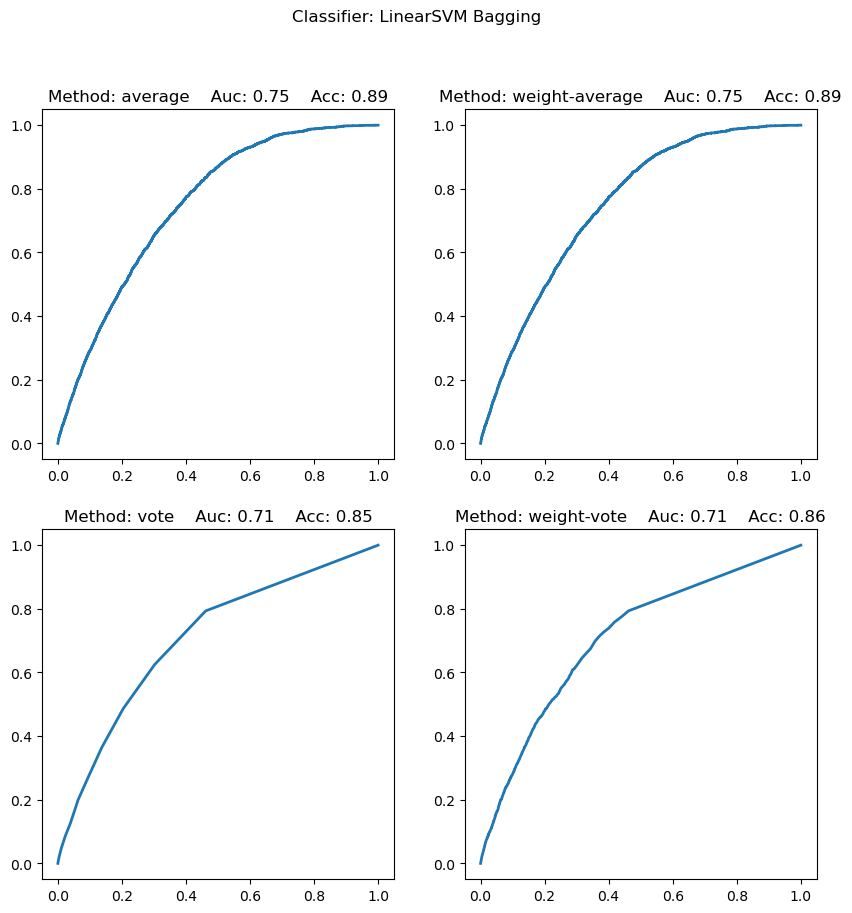

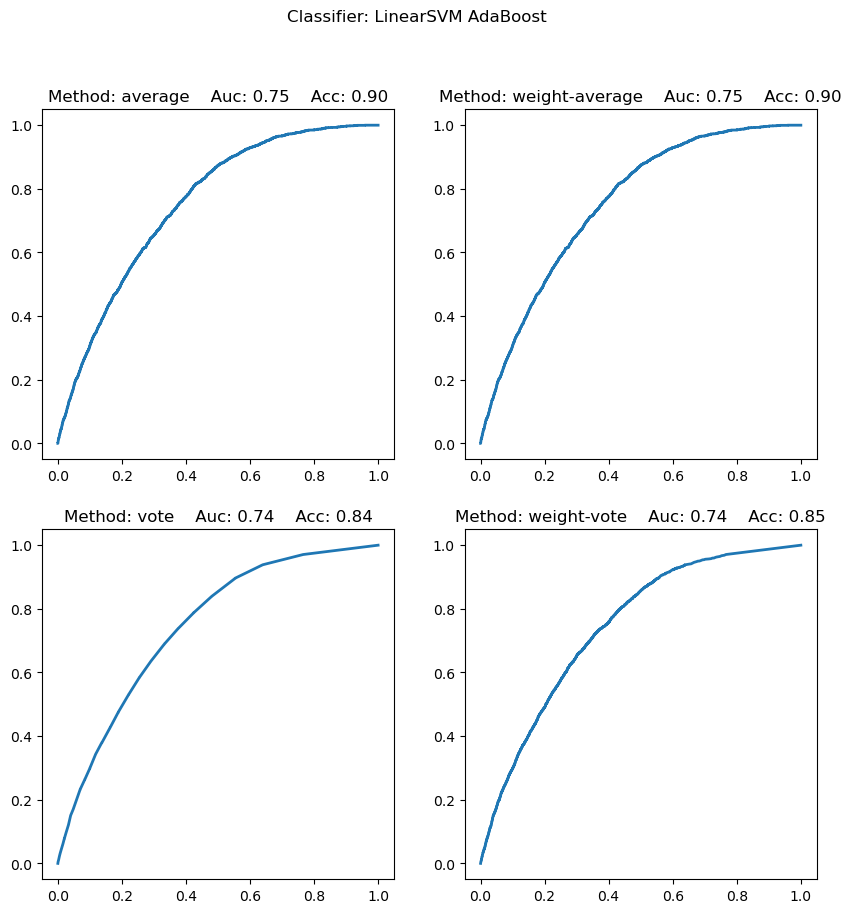

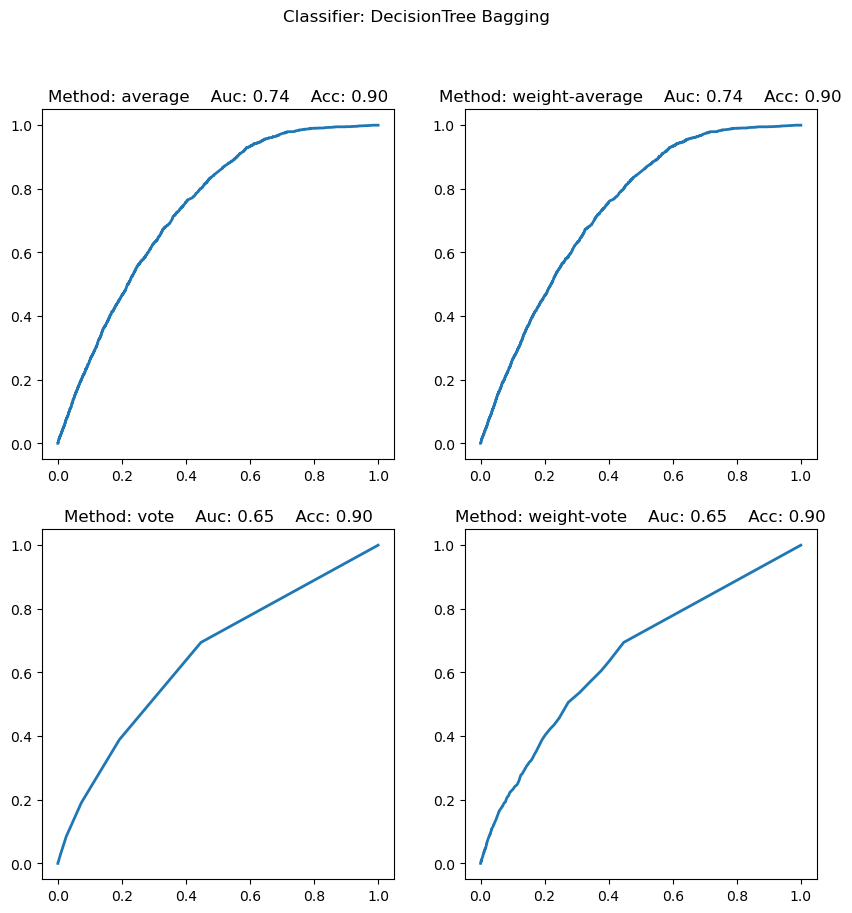

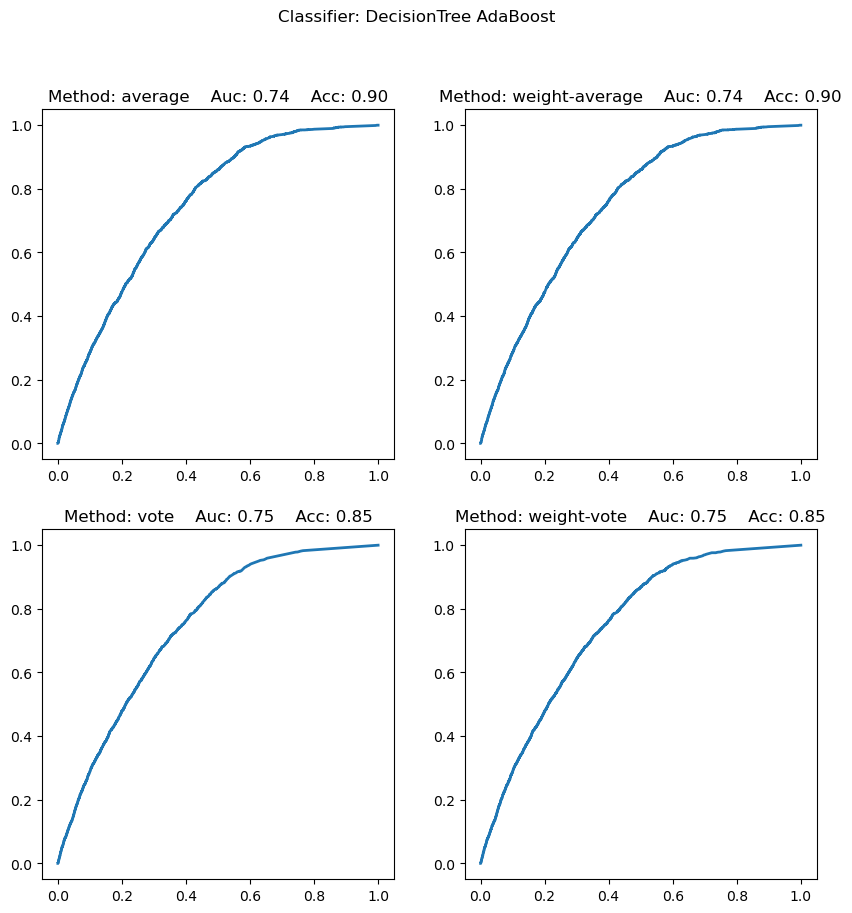

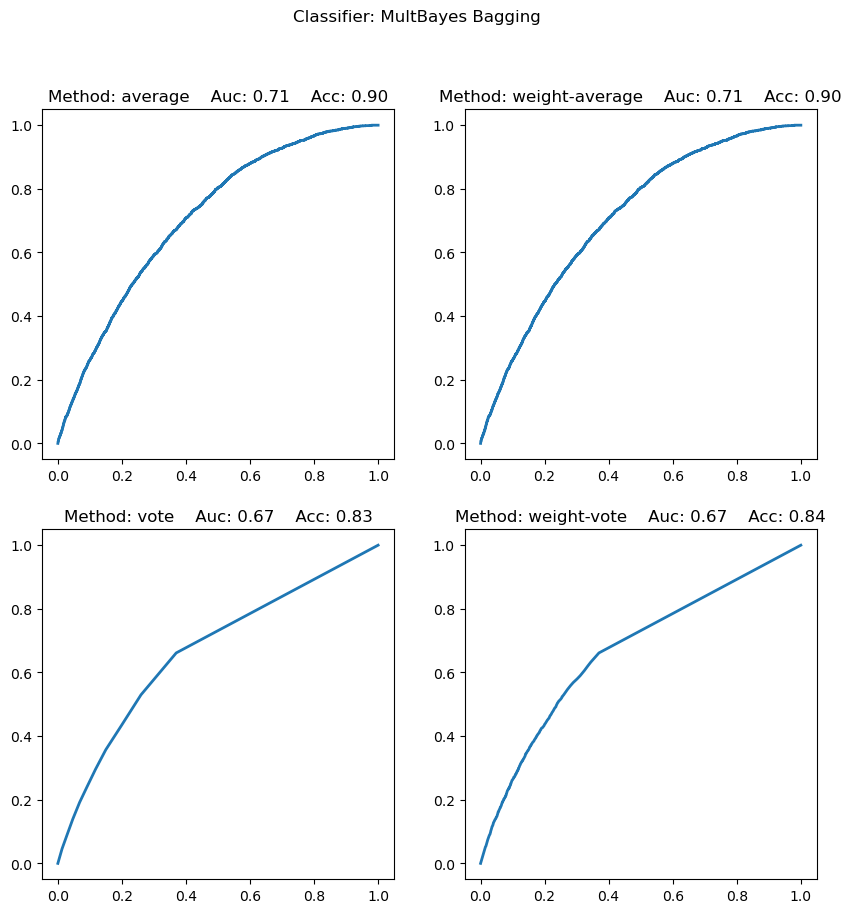

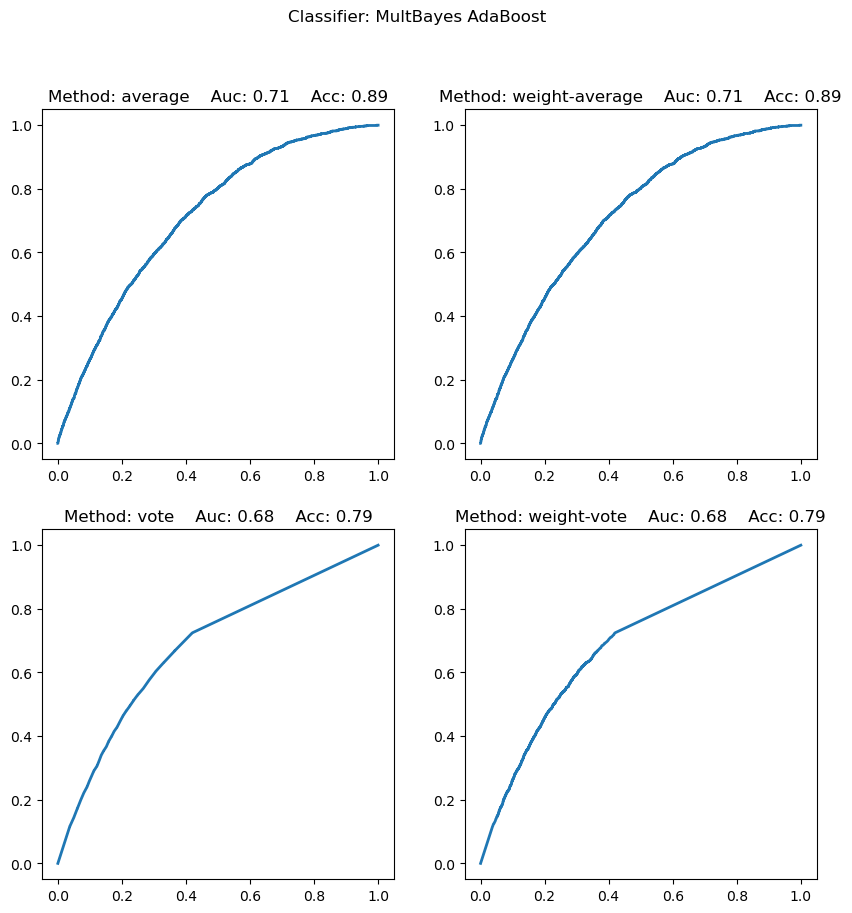

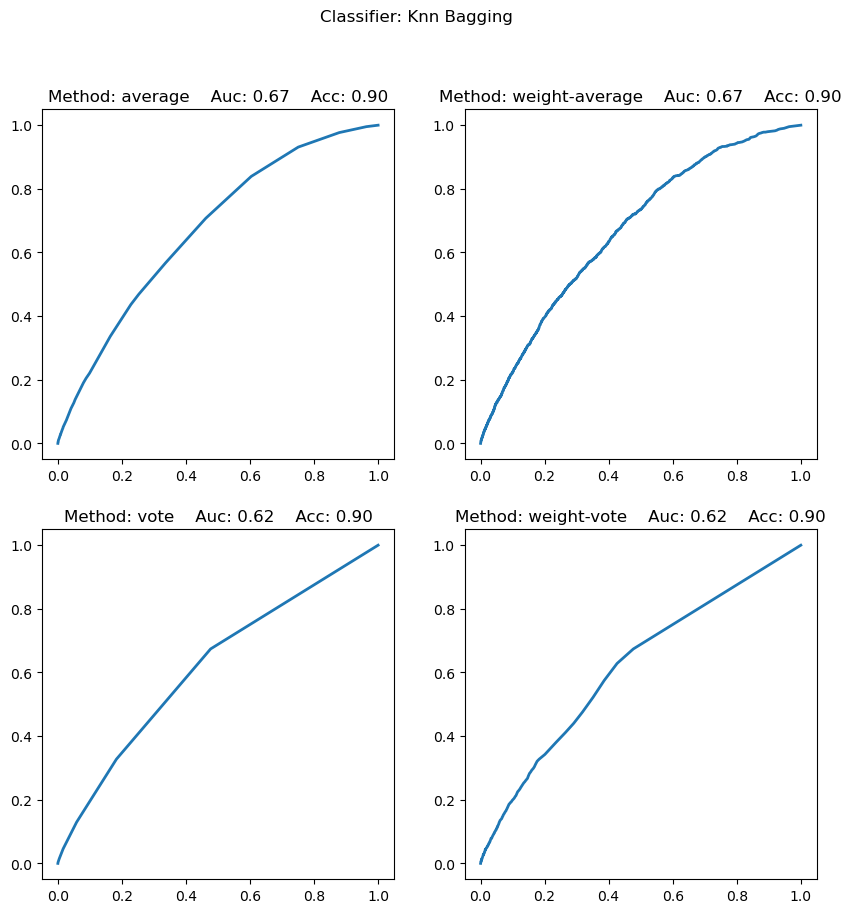

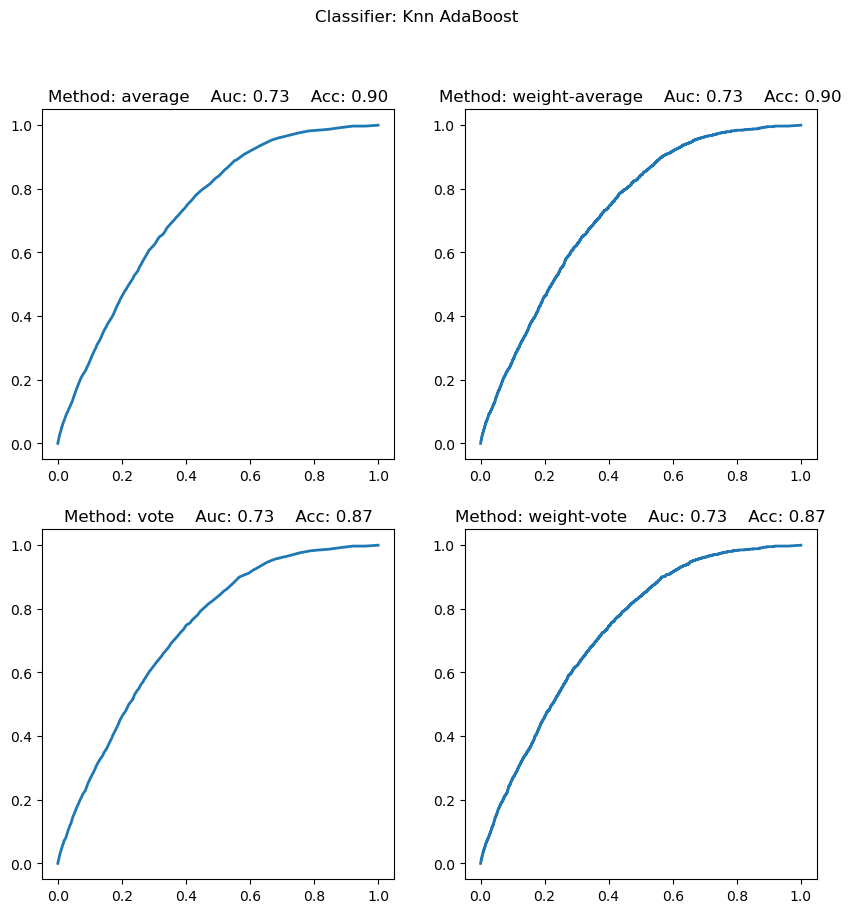

In [122]:
y_train = train_df['label']
y_test = test_df['label'].astype(int)

base_estimators = get_classifiers()

for name,clf in base_estimators.items():
    datas = [X_train, y_train, X_test, y_test]

    results_bagging, labels_bagging, weights_bagging = bagging([clf], datas, n_estimators=10, max_samples=0.1, max_features=0.5)
    weight(results_bagging, labels_bagging, weights_bagging, y_test, name + ' Bagging')

    results_adaboost, labels_adaboost, weights_adaboost = adaboost(clf, datas, n_estimators=30, learning_rate=1.0, max_samples=0.05, max_features=1.0)
    weight(results_adaboost, labels_adaboost, weights_adaboost, y_test, name + ' AdaBoost')

In [123]:
# Define a function to evaluate the model
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy}")

# Base estimators
base_estimators = get_classifiers()

# Train and evaluate ensemble models
for name, clf in base_estimators.items():
    # Data format: [X_train, y_train, X_test, y_test]
    datas = [X_train, y_train, X_test, y_test]

    # Bagging
    results_bagging, labels_bagging, weights_bagging = bagging([clf], datas, n_estimators=10, max_samples=0.1, max_features=0.5)
    y_pred_bagging = np.average(results_bagging, axis=0)  # average the results of all the bagging classifiers
    y_pred_bagging = (y_pred_bagging > 0.5).astype(int)
    print(f"Evaluation of Bagging with {name}:")
    evaluate_model(y_test, y_pred_bagging)

    # AdaBoost
    results_adaboost, labels_adaboost, weights_adaboost = adaboost(clf, datas, n_estimators=30, learning_rate=1.0, max_samples=0.05, max_features=1.0)
    y_pred_adaboost = np.average(results_adaboost, axis=0)  # average the results of all the adaboost classifiers
    y_pred_adaboost = (y_pred_adaboost > 0.5).astype(int)
    print(f"Evaluation of AdaBoost with {name}:")
    evaluate_model(y_test, y_pred_adaboost)


Evaluation of Bagging with LinearSVM:
Model accuracy: 0.8949058792042109
Evaluation of AdaBoost with LinearSVM:
Model accuracy: 0.9018645731108931
Evaluation of Bagging with DecisionTree:
Model accuracy: 0.9032027834775627
Evaluation of AdaBoost with DecisionTree:
Model accuracy: 0.9037380676242305
Evaluation of Bagging with MultBayes:
Model accuracy: 0.9040057096975644
Evaluation of AdaBoost with MultBayes:
Model accuracy: 0.8916049602997591
Evaluation of Bagging with Knn:
Model accuracy: 0.9035596395753412
Evaluation of AdaBoost with Knn:
Model accuracy: 0.8963333035953251
